# **Predictive Maintenance of Machines**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pathlib
import os

In [5]:
data_dir = '../induction_motor_electrical_faults/'

In [6]:
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('../induction_motor_electrical_faults')

In [8]:
files = list(data_dir.glob("*"))
files

[PosixPath('../induction_motor_electrical_faults/z_induction_motor_fault.txt'),
 PosixPath('../induction_motor_electrical_faults/z_induction_motor.txt'),
 PosixPath('../induction_motor_electrical_faults/y_induction_motor_fault.txt'),
 PosixPath('../induction_motor_electrical_faults/y_induction_motor.txt'),
 PosixPath('../induction_motor_electrical_faults/x_induction_motor_fault.txt'),
 PosixPath('../induction_motor_electrical_faults/x_induction_motor.txt')]

In [9]:
faultyFiles = list(data_dir.glob("*fault.txt"))
faultyFiles

[PosixPath('../induction_motor_electrical_faults/z_induction_motor_fault.txt'),
 PosixPath('../induction_motor_electrical_faults/y_induction_motor_fault.txt'),
 PosixPath('../induction_motor_electrical_faults/x_induction_motor_fault.txt')]

In [ ]:
healthyFiles = files.copy()

for item in faultyFiles:
    if item in healthyFiles:
      healthyFiles.remove(item)

In [ ]:
healthyFiles

[PosixPath('extracted_files/Data/z_induction_motor.txt'),
 PosixPath('extracted_files/Data/x_induction_motor.txt'),
 PosixPath('extracted_files/Data/y_induction_motor.txt')]

## Opening the files

In [ ]:
def read_data(data):
    for i in range(3):
        df = open(data[i], "r")
        lines = df.readlines()
        df.close()
        # remove /n at the end of each line
        for index, line in enumerate(lines):
            lines[index] = line.strip()
        yield np.array(lines).astype(np.float32)

In [ ]:
zh,yh,xh = read_data(healthyFiles)
xf,zf,yf = read_data(faultyFiles)

In [ ]:
xh

array([0.9375, 0.9375, 0.9375, ..., 0.625 , 0.625 , 0.625 ], dtype=float32)

In [ ]:
xf

array([-9.375, -9.375, -9.375, ..., -8.75 , -8.75 , -9.375], dtype=float32)

In [ ]:
healthy_col = [xh,yh,zh]
fault_col = [xf, yf, zf]

In [ ]:
def make_df(list):
    df = pd.DataFrame()
    df['x'] = list[0]
    df['y'] = list[1]
    df['z'] = list[2]
    return df

In [ ]:
healthyData = make_df(healthy_col)
faultyData = make_df(fault_col)

In [ ]:
healthyData.shape

(136272, 3)

In [ ]:
healthyData.describe()

,x,y,z
count,136272.000000,136272.000000,136272.000000
mean,-9.163136,1.085644,0.342266
std,6.073324,49.518223,49.345814
min,-10.312500,-9.687500,-10.000000
25%,-9.375000,0.937500,0.000000
50%,-9.375000,0.937500,0.312500
75%,-9.062500,0.937500,0.312500
max,1110.937500,18070.625000,18150.937500


## Finding peaks

In [ ]:
def find_peaks(data,height):
    peaks = []
    for i in range(len(data)):
        if(data[i]>height):
            peaks.append(i)
    return peaks

In [ ]:
peaks=find_peaks(healthyData['x'], -8) # this threshold is chosen after plotting the data
len(peaks)

655

In [ ]:
healthyData_filtered = healthyData.drop(peaks).reset_index(drop=True)

In [ ]:
# check if the peaks are removed
peaks_ = find_peaks(healthyData_filtered['x'],6)
peaks_

[]

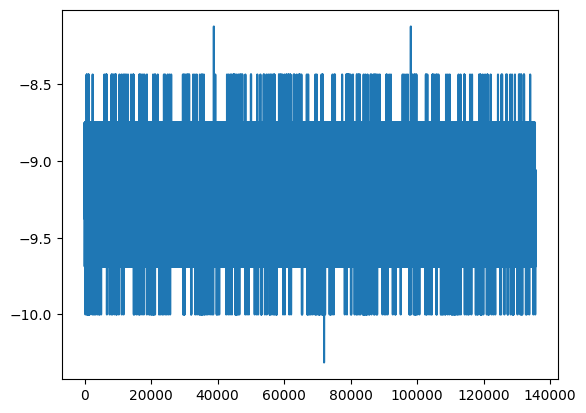

In [ ]:
plt.plot(healthyData_filtered['x'])

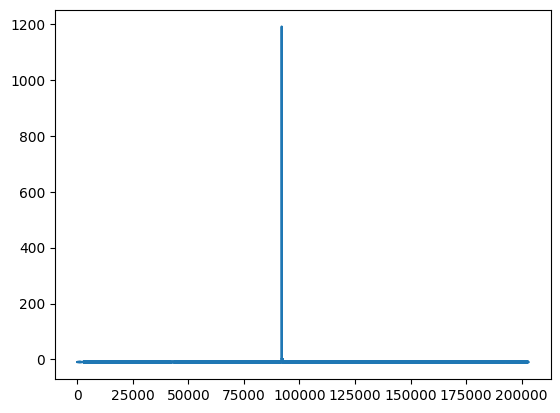

In [ ]:
plt.plot(faultyData['x'])

In [ ]:
peaks=find_peaks(faultyData['x'], -6)
len(peaks)

370

In [ ]:
faultyData = faultyData.drop(peaks).reset_index(drop=True)

In [ ]:
print(healthyData_filtered.shape , faultyData.shape)

(135617, 3) (202664, 3)


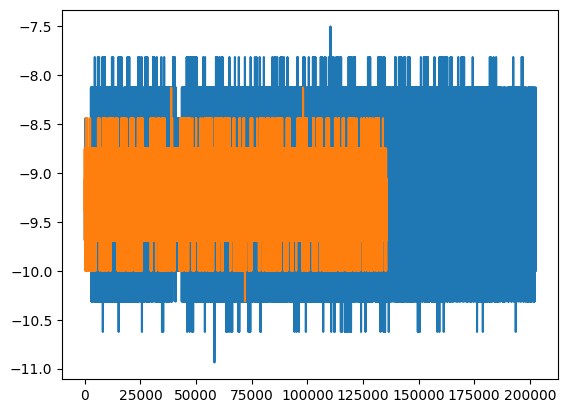

In [ ]:
plt.plot(faultyData['x'])
plt.plot(healthyData_filtered['x'])

we can see that faulty data has vibrations of higher amplitude than healthy data. We can directly take the statistical features and input in model, it will easily understand.

In [ ]:
# sampling rate = 1kHz = 1000
# This implies that 1000 samples were taken in 1 sec
# This implies 1 sample in 1 ms

## Sliding Window Data

In [ ]:
def prepare_data(data, duration, overlap):
    X = []
    window_size = duration  # Assuming 1 sample per millisecond
    step_size = int(window_size * (1 - overlap))  # Calculate step size based on overlap

    for start in range(0, len(data) - window_size + 1, step_size):
        window = data[start:start + window_size]
        X.append(window)

    return X

## Dividing into Train and Test set

In [ ]:
print(healthyData_filtered.shape[0]*0.8, faultyData.shape[0]*0.8)

108493.6 162131.2


In [ ]:
healthyTrainData = healthyData_filtered[:108493]
healthyTestData = healthyData_filtered[108493:]

faultyTrainData = faultyData[:162131]
faultyTestData = faultyData[162131:]

In [ ]:
xhTrain = prepare_data(healthyTrainData['x'],2000, 0.25)
xhTest = prepare_data(healthyTestData['x'],2000, 0.25)
xfTrain = prepare_data(faultyTrainData['x'], 2000, 0.25)
xfTest = prepare_data(faultyTestData['x'],2000, 0.25)

In [ ]:
len(xfTrain)

107

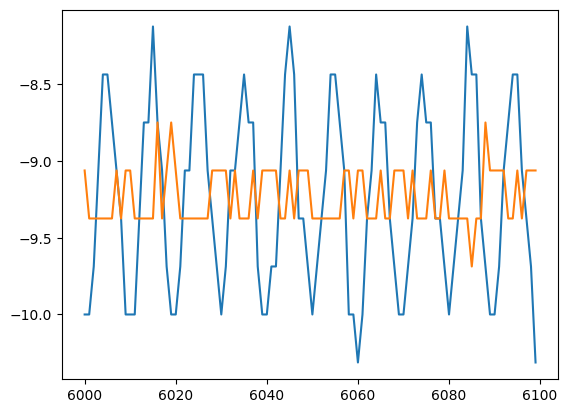

In [ ]:
plt.plot(xfTrain[4][:100])
plt.plot(xhTrain[4][:100])

## Feature Extraction

mean <br>
min<br>
max<br>
skewness<br>
kurtosis<br>
crest_factor<br>
Energy<br>

log-covariance features<br>
Shannon entropy and log-energy entropy<br>
FFT <br>

In [ ]:
xhTrain[0]

0      -9.3750
1      -9.3750
2      -9.0625
3      -9.0625
4      -9.0625
         ...  
1995   -9.3750
1996   -9.3750
1997   -9.0625
1998   -9.3750
1999   -9.0625
Name: x, Length: 2000, dtype: float32

### Statistical Features

In [ ]:
from scipy.stats import skew, kurtosis

In [ ]:
# statistical Features
def extract_skewness(data):
    skewness = []
    for i in range(len(data)):
      signal = np.array(data[i])
      skewness.append(skew(signal))
    return skewness
def extract_kurtosis(data):
    kurt = []
    for i in range(len(data)):
      signal = np.array(data[i])
      value = kurtosis(signal)
      kurt.append(value)
    return kurt

In [ ]:
skewness = extract_skewness(xhTrain)
kurt = extract_kurtosis(xhTrain)

### Mean, min, max features - 30 features

In [ ]:
# u1,u2,u3,u4, m1,m2,m3,m4, n1,n2,n3,n4 and there differences == total 30 features

In [ ]:
# mean, min, max
def extract_mean(data):
    u1 = []
    u2 = []
    u3 = []
    u4 = []
    for i in data:
      u1.append(np.array(i[:500]).mean())
      u2.append(np.array(i[500:1000]).mean())
      u3.append(np.array(i[1000:1500]).mean())
      u4.append(np.array(i[1000:]).mean())
    return np.array(u1),np.array(u2),np.array(u3),np.array(u4)
def extract_max(data):
    m1 = []
    m2 = []
    m3 = []
    m4 = []
    for i in data:
      m1.append(np.array(i[:500]).max())
      m2.append(np.array(i[500:1000]).max())
      m3.append(np.array(i[1000:1500]).max())
      m4.append(np.array(i[1000:]).max())
    return np.array(m1),np.array(m2),np.array(m3),np.array(m4)
def extract_min(data):
    n1 = []
    n2 = []
    n3 = []
    n4 = []
    for i in data:
      n1.append(np.array(i[:500]).min())
      n2.append(np.array(i[500:1000]).min())
      n3.append(np.array(i[1000:1500]).min())
      n4.append(np.array(i[1000:]).min())
    return np.array(n1),np.array(n2),np.array(n3),np.array(n4)
def extract_diff(arr1,arr2,arr3,arr4):
      return np.abs(arr1-arr2), np.abs(arr1-arr3), np.abs(arr1-arr4), np.abs(arr2-arr3), np.abs(arr2-arr4),np.abs(arr3-arr4),


In [ ]:
u1,u2,u3,u4 = extract_mean(xhTrain)
m1,m2,m3,m4 = extract_max(xhTrain)
n1,n2,n3,n4 = extract_min(xhTrain)
ud1,ud2,ud3,ud4,ud5,ud6 = extract_diff(u1,u2,u3,u4)
md1,md2,md3,md4,md5,md6 = extract_diff(m1,m2,m3,m4)
nd1,nd2,nd3,nd4,nd5,nd6 = extract_diff(n1,n2,n3,n4)

In [ ]:
fu1,fu2,fu3,fu4 = extract_mean(xfTrain)
fm1,fm2,fm3,fm4 = extract_max(xfTrain)
fn1,fn2,fn3,fn4 = extract_min(xfTrain)
fud1,fud2,fud3,fud4,fud5,fud6 = extract_diff(fu1,fu2,fu3,fu4)
fmd1,fmd2,fmd3,fmd4,fmd5,fmd6 = extract_diff(fm1,fm2,fm3,fm4)
fnd1,fnd2,fnd3,fnd4,fnd5,fnd6 = extract_diff(fn1,fn2,fn3,fn4)

### Log-covariance features

In [ ]:
u1

array([-9.246875, -9.2475  , -9.260625, -9.2625  , -9.256875, -9.2675  ,
       -9.26375 , -9.251875, -9.2425  , -9.256875, -9.2625  , -9.266875,
       -9.264375, -9.255   , -9.240625, -9.2625  , -9.245625, -9.25375 ,
       -9.261875, -9.2575  , -9.25    , -9.2525  , -9.255625, -9.243125,
       -9.25375 , -9.259375, -9.261875, -9.256875, -9.2425  , -9.244375,
       -9.23625 , -9.24875 , -9.26375 , -9.248125, -9.245   , -9.26    ,
       -9.250625, -9.235   , -9.24    , -9.234375, -9.25125 , -9.23375 ,
       -9.25125 , -9.2425  , -9.23375 , -9.235   , -9.2425  , -9.2475  ,
       -9.254375, -9.246875, -9.22875 , -9.244375, -9.230625, -9.24    ,
       -9.241875, -9.244375, -9.2525  , -9.233125, -9.245   , -9.250625,
       -9.245625, -9.23    , -9.24125 , -9.24375 , -9.240625, -9.248125,
       -9.2475  , -9.2425  , -9.24125 , -9.24875 , -9.234375],
      dtype=float32)

In [ ]:
def extract_feature_25(u1,u2,u3,u4,m1,m2,m3,m4,n1,n2,n3,n4,ud1,ud2,ud3,ud4,ud5,ud6,md1,md2,md3,md5,nd1,nd3,nd5):
  features_25 = []
  for i in range(len(u1)):
    feature_vector = []
    feature_vector.append(u1[i])
    feature_vector.append(u2[i])
    feature_vector.append(u3[i])
    feature_vector.append(u4[i])
    feature_vector.append(m1[i])
    feature_vector.append(m2[i])
    feature_vector.append(m3[i])
    feature_vector.append(m4[i])
    feature_vector.append(n1[i])
    feature_vector.append(n2[i])
    feature_vector.append(n3[i])
    feature_vector.append(n4[i])
    feature_vector.append(ud1[i])
    feature_vector.append(ud2[i])
    feature_vector.append(ud3[i])
    feature_vector.append(ud4[i])
    feature_vector.append(ud5[i])
    feature_vector.append(ud6[i])
    feature_vector.append(md1[i])
    feature_vector.append(md2[i])
    feature_vector.append(md3[i])
    feature_vector.append(md5[i])
    feature_vector.append(nd1[i])
    feature_vector.append(nd3[i])
    feature_vector.append(nd5[i])
    features_25.append(feature_vector)
  return features_25

In [ ]:
features_25 = extract_feature_25(u1,u2,u3,u4,m1,m2,m3,m4,n1,n2,n3,n4,ud1,ud2,ud3,ud4,ud5,ud6,md1,md2,md3,md5,nd1,nd3,nd5)

In [ ]:
len(fu1)

107

In [ ]:
from scipy.linalg import logm

In [ ]:
len(features_25)

71

In [ ]:
len(features_25[0])

25

Log Covariance

In [ ]:
def log_covariance_features(features_25):
    log_cov = []
    for i in range(len(features_25)):
      array = features_25[i]
      # Reshape to form a 5x5 matrix
      M = array.reshape(5, 5)
      # Compute the covariance matrix
      cov_matrix = np.cov(M, rowvar=False)
      # Compute the matrix logarithm of the covariance matrix
      log_cov_matrix = logm(cov_matrix)
      # Extract the upper triangular elements (including the diagonal)
      upper_triangular_elements = log_cov_matrix[np.triu_indices(5)]
      log_cov.append(upper_triangular_elements)
    return log_cov


In [ ]:
log_cov = log_covariance_features(np.array(features_25))

In [ ]:
log_cov[0]

array([ -1.26287284,   5.05956391,   1.17427174,  -3.07534075,
         2.89241234,  -1.43517664,  -0.67306346,   3.76190843,
        -2.40865835,  -0.93321444,   6.71091986,  -2.12075137,
       -17.90066336,  16.38344393, -10.63319573])

### Shannon entropy and log-energy entropy

In [ ]:
def shannon_entropy(data):
    """
    Calculate the Shannon entropy of a signal.

    Parameters:
    signal (array-like): Input signal.

    Returns:
    float: Shannon entropy of the signal.
    """
    Shannon_entropy = []
    for i in range(len(data)):
      signal = np.array(data[i])
      # Normalize the signal
      normalized_signal = signal / np.sum(signal)
      # Calculate the Shannon entropy
      entropy = -np.sum(normalized_signal * np.log(normalized_signal + np.finfo(float).eps))  # Adding eps to avoid log(0)
      Shannon_entropy.append(entropy)
    return Shannon_entropy

def log_energy_entropy(data):
    """
    Calculate the log-energy entropy of a signal.

    Parameters:
    signal (array-like): Input signal.

    Returns:
    float: Log-energy entropy of the signal.
    """
    log_energy = []
    for i in range(len(data)):
      signal = np.array(data[i])
      # Split the signal into two sub-windows
      mid_point = len(signal) // 2
      first_half = signal[:mid_point]
      second_half = signal[mid_point:]

      # Calculate the log-energy entropy
      energy = np.sum(np.log(first_half ** 2 + np.finfo(float).eps)) + np.sum(np.log(second_half ** 2 + np.finfo(float).eps))
      log_energy.append(energy)
    return log_energy

In [ ]:
s_entropy = shannon_entropy(xhTrain)

In [ ]:
l_entropy = log_energy_entropy(xhTrain)

### FFT

In [ ]:
def compute_fft(data, sampling_rate=1000):
    """
    Compute the Fast Fourier Transform (FFT) and frequency bins of a given time series.

    Parameters:
    signal (array-like): Input signal amplitudes.
    sampling_rate (float): Sampling rate of the signal.

    Returns:
    tuple: (frequencies, fft_result)
        - frequencies (array-like): Frequency bins corresponding to the FFT.
        - fft_result (array-like): FFT of the signal.
    """
    freq = []
    fft = []
    for i in range(len(data)):
      signal = np.array(data[i])
      # Number of samples in the signal
      N = len(signal)

      # Compute the FFT
      fft_result = np.fft.fft(signal)[:N // 2]

      # Compute the frequency bins
      frequencies = np.fft.fftfreq(N, d=1/sampling_rate)[:N // 2]
      freq.append(frequencies)
      fft.append(fft_result)
    return freq,fft

In [ ]:
frequencies, fft = compute_fft(xhTrain)

### Crest-factor

In [ ]:
def extract_crest_factor(data):
    crest_factor = []
    for i in range(len(data)):
      waveform = np.array(data[i])
      # Convert input to a numpy array
      waveform = np.array(waveform)
      # Calculate the peak value
      peak_value = np.max(np.abs(waveform))
      # Calculate the RMS value
      rms_value = np.sqrt(np.mean(waveform**2))
      # Calculate the crest factor
      factor = peak_value / rms_value
      crest_factor.append(factor)
    return crest_factor

In [ ]:
crestFactor = extract_crest_factor(xhTrain)

### Energy

In [ ]:
def extract_energy(data):
  total_energy = []
  for i in range(len(data)):
    signal = np.array(data[i])
    energy = np.sum(signal**2)
    total_energy.append(energy)
  return total_energy

In [ ]:
energy = extract_energy(xhTrain)

### RMS

In [ ]:
def extract_rms(data):
  rms = []
  for i in range(len(data)):
    signal = np.array(data[i])
    squared_signal = signal ** 2
    # Calculate the mean of the squared values
    mean_squared_signal = np.mean(squared_signal)
    # Calculate the RMS value by taking the square root of the mean of squared values
    rms_value = np.sqrt(mean_squared_signal)
    rms.append(rms_value)
  return rms

In [ ]:
rms = extract_rms(xhTrain)

In [ ]:
trainHx = pd.DataFrame()
trainHx['rms'] = rms
trainHx['energy'] = energy
trainHx['skewness'] = skewness
trainHx['kurtosis'] = kurt
trainHx['crestFactor'] = crestFactor
trainHx['ShannonEntropy'] = s_entropy
trainHx['LogEnergyEntropy'] = l_entropy
trainHx['LogCovariance'] = log_cov

In [ ]:
len(log_cov[0])

15

In [ ]:
trainHx[['lc1','lc2','lc3','lc4','lc5','lc6','lc7','lc8','lc9','lc10','lc11','lc12','lc13','lc14','lc15']] = pd.DataFrame(trainHx['LogCovariance'].tolist())
trainHx.drop('LogCovariance', axis=1, inplace=True)

In [ ]:
trainHx

,rms,energy,skewness,kurtosis,crestFactor,ShannonEntropy,LogEnergyEntropy,lc1,lc2,lc3,...,lc6,lc7,lc8,lc9,lc10,lc11,lc12,lc13,lc14,lc15
0,9.260469,171512.593750,0.080020,0.726111,1.079859,7.600666,8901.126953,-1.262873+0.000000j,5.059564+0.000000j,1.174272+0.000000j,...,-1.435177+0.000000j,-0.673063+0.000000j,3.761908+0.000000j,-2.408658+0.000000j,-0.933214+0.000000j,6.710920+0.000000j,-2.120751+0.000000j,-17.900663+0.000000j,16.383444+0.000000j,-10.633196+0.000000j
1,9.258366,171434.671875,0.110034,0.289443,1.080104,7.600691,8900.416016,-7.890554+0.000000j,11.319243+0.000000j,-0.562406+0.000000j,...,-7.319883+0.000000j,1.081459+0.000000j,-6.833051+0.000000j,7.058786+0.000000j,-0.180694+0.000000j,3.472014+0.000000j,0.559399+0.000000j,-8.504908+0.000000j,9.879140+0.000000j,-6.636256+0.000000j
2,9.261809,171562.218750,0.089798,0.198294,1.079703,7.600690,8901.898438,-7.779300+0.000000j,11.485951+0.000000j,-0.609909+0.000000j,...,-7.777799+0.000000j,1.182235+0.000000j,-2.618600+0.000000j,2.396569+0.000000j,-1.751315+0.000000j,7.907225+0.000000j,-2.462577+0.000000j,-18.412753+0.000000j,15.604256+0.000000j,-9.469829+0.000000j
3,9.258246,171430.265625,0.289865,0.177759,1.080118,7.600687,8900.329102,-14.827984+0.000000j,18.505008+0.000000j,-2.736291+0.000000j,...,-14.826339+0.000000j,3.349134+0.000000j,-2.665122+0.000000j,0.137439+0.000000j,-0.383173+0.000000j,2.712244+0.000000j,1.540827+0.000000j,-1.379857+0.000000j,3.130429+0.000000j,-0.584684+0.000000j
4,9.264484,171661.328125,0.233110,0.338560,1.079391,7.600688,8903.036133,-13.688512+0.000000j,16.856933+0.000000j,5.137696+0.000000j,...,-12.634890+0.000000j,-4.377546+0.000000j,4.214764+0.000000j,0.615315+0.000000j,-2.128084+0.000000j,4.756303+0.000000j,1.155544+0.000000j,-3.116357+0.000000j,2.880175+0.000000j,0.107050+0.000000j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,9.244857,170934.765625,0.075239,0.549339,1.081683,7.600682,8894.499023,-14.343343+0.000000j,18.091628+0.000000j,4.195075+0.000000j,...,-14.366628+0.000000j,-3.631970+0.000000j,4.005328+0.000000j,0.519557+0.000000j,-1.191751+0.000000j,4.077597+0.000000j,0.998533+0.000000j,-3.198890+0.000000j,3.633306+0.000000j,-0.552820+0.000000j
67,9.241983,170828.515625,0.051700,-0.130745,1.082019,7.600688,8893.308594,-15.300267+0.000000j,18.392495+0.000000j,0.797250+0.000000j,...,-14.155889+0.000000j,-0.151714+0.000000j,-0.291067+0.000000j,0.779268+0.000000j,-0.069058+0.000000j,2.232955+0.000000j,1.764568+0.000000j,-1.393731+0.000000j,3.588999+0.000000j,-1.264664+0.000000j
68,9.245980,170976.281250,0.165458,0.354271,1.081551,7.600678,8894.958984,-1.562420+0.000000j,5.191172+0.000000j,1.402159+0.000000j,...,-1.451120+0.000000j,-0.865137+0.000000j,4.041829+0.000000j,-2.644642+0.000000j,-1.049789+0.000000j,6.970962+0.000000j,-2.321787+0.000000j,-18.639816+0.000000j,16.974069+0.000000j,-11.120919+0.000000j
69,9.246173,170983.406250,0.163774,0.272476,1.081529,7.600675,8895.009766,-14.477706+1.544187j,18.081898-1.537017j,-1.964618+0.218731j,...,-14.333455+1.529880j,2.489038-0.217715j,0.241619-0.005618j,-2.015913+0.236380j,-0.106348+0.030983j,2.326889+0.000799j,1.620858-0.033639j,-1.484980+0.000021j,3.600456-0.000868j,-1.052617+0.036523j


In [ ]:
list(trainHx.columns)

['rms',
 'energy',
 'skewness',
 'kurtosis',
 'crestFactor',
 'ShannonEntropy',
 'LogEnergyEntropy',
 'lc1',
 'lc2',
 'lc3',
 'lc4',
 'lc5',
 'lc6',
 'lc7',
 'lc8',
 'lc9',
 'lc10',
 'lc11',
 'lc12',
 'lc13',
 'lc14',
 'lc15']

In [ ]:
complex_col = ['lc1',
 'lc2',
 'lc3',
 'lc4',
 'lc5',
 'lc6',
 'lc7',
 'lc8',
 'lc9',
 'lc10',
 'lc11',
 'lc12',
 'lc13',
 'lc14',
 'lc15']

In [ ]:
def split_complex_numbers(list,data):
  df = data.copy()
  for i in list:
    df[['r'+ i, 'i'+ i]] = df[i].apply(lambda x: pd.Series([x.real, x.imag]))

    # Drop the original complex column if needed
    df.drop(i, axis=1, inplace=True)
  return df

In [ ]:
HdfX = split_complex_numbers(complex_col,trainHx)

fault data

In [ ]:
fu1,fu2,fu3,fu4 = extract_mean(xfTrain)
fm1,fm2,fm3,fm4 = extract_max(xfTrain)
fn1,fn2,fn3,fn4 = extract_min(xfTrain)
fud1,fud2,fud3,fud4,fud5,fud6 = extract_diff(fu1,fu2,fu3,fu4)
fmd1,fmd2,fmd3,fmd4,fmd5,fmd6 = extract_diff(fm1,fm2,fm3,fm4)
fnd1,fnd2,fnd3,fnd4,fnd5,fnd6 = extract_diff(fn1,fn2,fn3,fn4)
F_features_25 = extract_feature_25(fu1,fu2,fu3,fu4,fm1,fm2,fm3,fm4,fn1,fn2,fn3,fn4,fud1,fud2,fud3,fud4,fud5,fud6,fmd1,fmd2,fmd3,fmd5,fnd1,fnd3,fnd5)

In [ ]:
trainFx = pd.DataFrame()
trainFx['rms'] = extract_rms(xfTrain)
trainFx['energy'] = extract_energy(xfTrain)
trainFx['skewness'] = extract_skewness(xfTrain)
trainFx['kurtosis'] = extract_kurtosis(xfTrain)
trainFx['crestFactor'] = extract_crest_factor(xfTrain)
trainFx['ShannonEntropy'] = shannon_entropy(xfTrain)
trainFx['LogEnergyEntropy'] = log_energy_entropy(xfTrain)
trainFx['LogCovariance'] = log_covariance_features(np.array(F_features_25))

In [ ]:
trainFx[['lc1','lc2','lc3','lc4','lc5','lc6','lc7','lc8','lc9','lc10','lc11','lc12','lc13','lc14','lc15']] = pd.DataFrame(trainFx['LogCovariance'].tolist())
trainFx.drop('LogCovariance', axis=1, inplace=True)

In [ ]:
FdfX = split_complex_numbers(complex_col,trainFx)

In [ ]:
print(HdfX.shape,FdfX.shape)

(71, 37) (107, 37)


In [ ]:
Hy = np.zeros(71, dtype='int')
Fy = np.zeros(107, dtype='int')+1

I will use the test data in the end

For now will divide this into two :)




In [ ]:
HdfX_train = HdfX[:55]
HdfX_test = HdfX[55:]

FdfX_train = FdfX[:87]
FdfX_test = FdfX[87:]

Hy_train = Hy[:55]
Hy_test = Hy[55:]

Fy_train = Fy[:87]
Fy_test = Fy[87:]

In [ ]:
trainX = pd.concat([HdfX_train,FdfX_train], axis=0)
testX = pd.concat([HdfX_test,FdfX_test], axis=0)
trainy = np.concatenate((Hy_train,Fy_train))
testy = np.concatenate((Hy_test,Fy_test))

In [ ]:
full_trainX = pd.concat([HdfX,FdfX], axis=0)
full_trainy = np.concatenate((Hy,Fy))

In [ ]:
# xhTest, xfTest ----- True test sets

In [ ]:
xhTest_mmm = [None]*25
xfTest_mmm = [None]*25

In [ ]:
thu1,thu2,thu3,thu4 = extract_mean(xhTest)
thm1,thm2,thm3,thm4 = extract_max(xhTest)
thn1,thn2,thn3,thn4 = extract_min(xhTest)
thud1,thud2,thud3,thud4,thud5,thud6 = extract_diff(thu1,thu2,thu3,thu4)
thmd1,thmd2,thmd3,thmd4,thmd5,thmd6 = extract_diff(thm1,thm2,thm3,thm4)
thnd1,thnd2,thnd3,thnd4,thnd5,thnd6 = extract_diff(thn1,thn2,thn3,thn4)
testH_features_25 = extract_feature_25(thu1,thu2,thu3,thu4,thm1,thm2,thm3,thm4,thn1,thn2,thn3,thn4,thud1,thud2,thud3,thud4,thud5,thud6,thmd1,thmd2,thmd3,thmd5,thnd1,thnd3,thnd5)

In [ ]:
tfu1,tfu2,tfu3,tfu4 = extract_mean(xfTest)
tfm1,tfm2,tfm3,tfm4 = extract_max(xfTest)
tfn1,tfn2,tfn3,tfn4 = extract_min(xfTest)
tfud1,tfud2,tfud3,tfud4,tfud5,tfud6 = extract_diff(tfu1,tfu2,tfu3,tfu4)
tfmd1,tfmd2,tfmd3,tfmd4,tfmd5,tfmd6 = extract_diff(tfm1,tfm2,tfm3,tfm4)
tfnd1,tfnd2,tfnd3,tfnd4,tfnd5,tfnd6 = extract_diff(tfn1,tfn2,tfn3,tfn4)
testF_features_25 = extract_feature_25(tfu1,tfu2,tfu3,tfu4,tfm1,tfm2,tfm3,tfm4,tfn1,tfn2,tfn3,tfn4,tfud1,tfud2,tfud3,tfud4,tfud5,tfud6,tfmd1,tfmd2,tfmd3,tfmd5,tfnd1,tfnd3,tfnd5)

In [ ]:
testFx = pd.DataFrame()
testFx['rms'] = extract_rms(xfTest)
testFx['energy'] = extract_energy(xfTest)
testFx['skewness'] = extract_skewness(xfTest)
testFx['kurtosis'] = extract_kurtosis(xfTest)
testFx['crestFactor'] = extract_crest_factor(xfTest)
testFx['ShannonEntropy'] = shannon_entropy(xfTest)
testFx['LogEnergyEntropy'] = log_energy_entropy(xfTest)
testFx['LogCovariance'] = log_covariance_features(np.array(testF_features_25))
testFx[['lc1','lc2','lc3','lc4','lc5','lc6','lc7','lc8','lc9','lc10','lc11','lc12','lc13','lc14','lc15']] = pd.DataFrame(testFx['LogCovariance'].tolist())
testFx.drop('LogCovariance', axis=1, inplace=True)
test_FdfX = split_complex_numbers(complex_col,testFx)

In [ ]:
testhx = pd.DataFrame()
testhx['rms'] = extract_rms(xhTest)
testhx['energy'] = extract_energy(xhTest)
testhx['skewness'] = extract_skewness(xhTest)
testhx['kurtosis'] = extract_kurtosis(xhTest)
testhx['crestFactor'] = extract_crest_factor(xhTest)
testhx['ShannonEntropy'] = shannon_entropy(xhTest)
testhx['LogEnergyEntropy'] = log_energy_entropy(xhTest)
testhx['LogCovariance'] = log_covariance_features(np.array(testH_features_25))
testhx[['lc1','lc2','lc3','lc4','lc5','lc6','lc7','lc8','lc9','lc10','lc11','lc12','lc13','lc14','lc15']] = pd.DataFrame(testhx['LogCovariance'].tolist())
testhx.drop('LogCovariance', axis=1, inplace=True)
test_hdfX = split_complex_numbers(complex_col,testhx)

In [ ]:
y_test_H = np.zeros(len(test_hdfX), dtype='int')
y_test_F = np.zeros(len(test_FdfX), dtype='int') + 1

In [ ]:
original_testX = pd.concat([test_hdfX,test_FdfX], axis=0)
original_testy = np.concatenate((y_test_H,y_test_F))

## Feature Selection

## Model Training

In [ ]:
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

In [ ]:
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [ ]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(algorithm="SAMME", random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

In [ ]:
for name, clf in zip(names, classifiers):
        print(name)
        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(full_trainX, full_trainy)
        y_pred = clf.predict(original_testX)
        print(y_pred)
        score = clf.score(original_testX, original_testy)
        print("Score : ",score)
        print("\n")

Nearest Neighbors
[0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
Score :  0.8837209302325582


Linear SVM
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
Score :  1.0


RBF SVM
[0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
Score :  0.6511627906976745


Gaussian Process
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
Score :  1.0


Decision Tree
[0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
Score :  0.8837209302325582


Random Forest
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
Score :  1.0


Neural Net
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
Score :  1.0


AdaBoost
[0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
Score :  0.9069767441860465


Naive 

In [ ]:
# Linear SVM, Gaussian Process, Random Forest, Neural Net, Naive Bayes, QDA

# these algorithms gave 100% accuracy